In [159]:
# # 🐉 D&D Monster Analysis: End-to-End ML Pipeline
#
# **Objective:** Transform raw Dungeons & Dragons monster data into a clean, numeric dataset ready for Machine Learning models (Regression/Classification).
#
# **Pipeline Steps:**
# 1.  **Initialization:** Load data and normalize headers.
# 2.  **EDA & Cleaning:** Analyze the target variable and handle physical attributes (Size).
# 3.  **Feature Engineering:** Quantify textual data (Actions, Defenses).
# 4.  **Imputation:** Apply Domain Knowledge (D&D Rules) to fill missing skills.
# 5.  **Finalization:** Encoding categorical variables and removing statistical noise.
#
# ---


In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

# Configuration for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# ==========================================
# 1. LOADING & NORMALIZATION
# ==========================================
print("--- PHASE 1: Loading Data ---")

# Robust loading: try default path, fallback to root
try:
    df = pd.read_csv("./data/monsters_og.csv")
except FileNotFoundError:
    try:
        df = pd.read_csv("monsters.csv")
    except FileNotFoundError:
        print("❌ CRITICAL ERROR: File 'monsters.csv' not found.")
        raise

# 🛠️ CRITICAL STEP: Column Normalization
# We convert all headers to lowercase and strip spaces.
# This prevents errors where 'Size', 'size', or 'SIZE ' are treated differently.
df.columns = df.columns.str.lower().str.strip().str.replace("!", "", regex=False)

print(f"✅ Dataset Loaded: {df.shape[0]} rows, {df.shape[1]} columns.")
print(f"   Columns found (sample): {df.columns[:10].tolist()}")


--- PHASE 1: Loading Data ---
✅ Dataset Loaded: 2435 rows, 71 columns.
   Columns found (sample): ['slug', 'desc', 'name', 'size', 'type', 'subtype', 'group', 'alignment', 'armor_class', 'armor_desc']


In [161]:
# ## Phase 2: Exploratory Data Analysis (EDA)
#
# Before transforming the data, we must understand its initial state.
#
# ### 📊 Graph 1: Dataset Diagnostics
# * **Left (Target Distribution):** We examine the **Challenge Rating (CR)**.
#     * *Goal:* Check for class imbalance. Usually, low-CR monsters (goblins, beasts) are more common than high-CR monsters (Ancient Dragons).
# * **Right (Missing Values):** A Heatmap of `null` values.
#     * *Goal:* Identify sparse columns. Yellow lines indicate missing data. We expect `skills`, `senses`, and `spells` to have many nulls because not every monster has every ability.


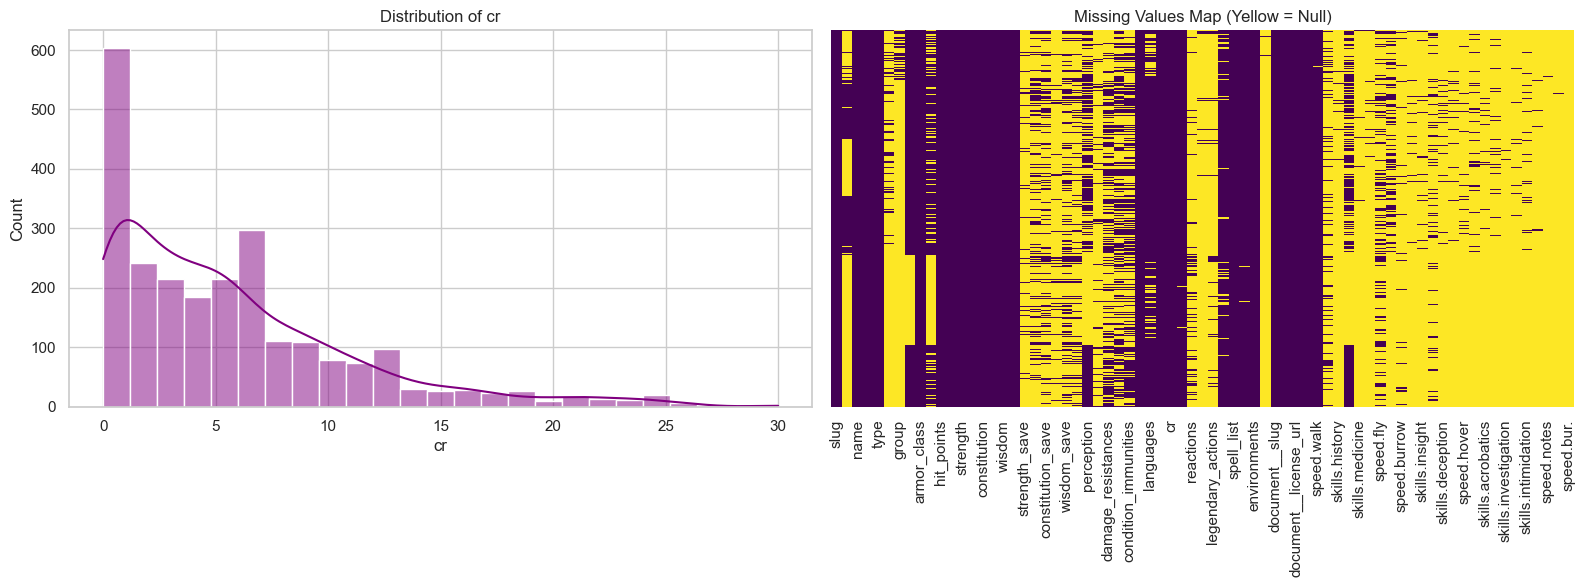

In [162]:
# 📊 GRAPH 1: Diagnostics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# A. Target Distribution
# Handle case where CR might be string fractions ("1/4") or floats
target_col = 'cr' if 'cr' in df.columns else 'challenge_rating'
if pd.api.types.is_numeric_dtype(df[target_col]):
    sns.histplot(df[target_col], bins=25, kde=True, ax=axes[0], color='purple')
else:
    # If string, show top frequencies
    top = df[target_col].value_counts().head(10)
    sns.barplot(x=top.index, y=top.values, ax=axes[0], palette="magma", hue=top.index, legend=False)
axes[0].set_title(f'Distribution of {target_col}')

# B. Missing Values Heatmap
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[1])
axes[1].set_title('Missing Values Map (Yellow = Null)')

plt.tight_layout()
plt.show()


In [163]:
# ## Phase 3: Physical Attributes (Size)
#
# ### 🛠️ Transformation: Ordinal Mapping of Size
# In D&D, size is not just a label; it is a **hierarchy**.
# * *Tiny* < *Small* < *Medium* < ... < *Gargantuan*.
#
# We cannot use One-Hot Encoding (binary columns) because the model would lose the information that "Gargantuan" is significantly larger than "Tiny". We map these to integers (1-7) to preserve this mathematical relationship.
#
# *Note:* We use robust string matching (`.str.lower()`) to ensure "Medium", "medium", and "MEDIUM" are all mapped correctly.


In [164]:
print("\n--- PHASE 2: Cleaning & Size Transformation ---")

# 1. SIZE MAPPING
size_map = {
    'tiny': 1, 'small': 2, 'medium': 3, 'large': 4,
    'huge': 5, 'gargantuan': 6, 'titanic': 7
}

# Robust Logic: Find the 'size' column regardless of prior naming
if 'size_numeric' in df.columns:
    print("ℹ️ 'size_numeric' already exists.")
elif 'size' in df.columns:
    # Convert to string -> lowercase -> map -> fill NaN with 3 (Medium) -> convert to int
    df['size_numeric'] = df['size'].astype(str).str.lower().map(size_map)
    df['size_numeric'] = df['size_numeric'].fillna(3).astype(int)
    # Drop original text column
    df = df.drop(columns=['size'])
    print("✅ Transformed 'size' (text) into 'size_numeric' (1-7).")
else:
    # Fallback if size is missing entirely
    print("⚠️ WARNING: 'size' column not found. Defaulting to 3 (Medium).")
    df['size_numeric'] = 3

# 2. GENERAL CLEANING
# Remove redundant target string if numeric exists
if 'challenge_rating' in df.columns:
    df = df.drop(columns=['challenge_rating'])

# Remove Metadata / Lore columns that do not affect stats
cols_to_drop = [
    'page_no', 'img_main', 'document__slug', 'document__title',
    'document__license_url', 'document__url', 'environments',
    'legendary_desc', 'speed.notes', 'speed.lightwalking', 'speed.bur.'
]
# Drop only columns that actually exist
existing_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=existing_drop)
print(f"✅ Removed {len(existing_drop)} metadata columns.")



--- PHASE 2: Cleaning & Size Transformation ---
✅ Transformed 'size' (text) into 'size_numeric' (1-7).
✅ Removed 11 metadata columns.


In [165]:
# ### 📊 Graph 2: Physical Consistency Check
# **Size vs. Hit Points (HP)**
#
# * *Hypothesis:* Larger monsters should have more Hit Points.
# * *Visual Check:* We expect the boxplots to ascend in a "staircase" pattern from left to right. This confirms `size_numeric` is a valid predictor.




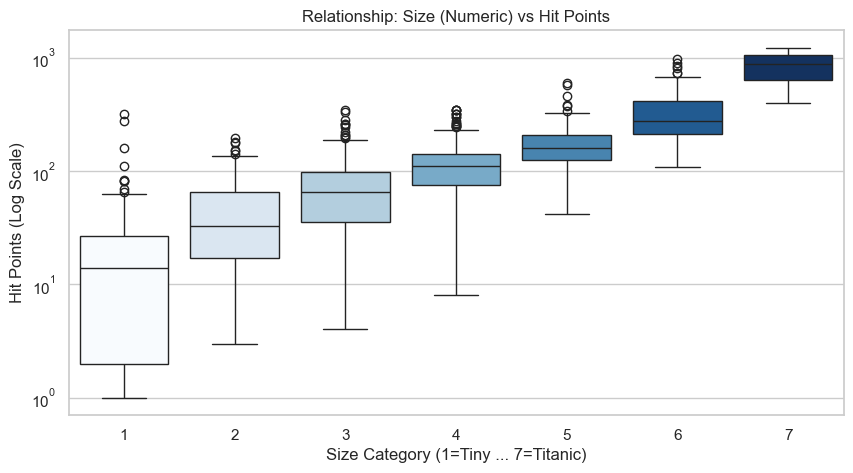

In [166]:
# 📊 GRAPH 2
plt.figure(figsize=(10, 5))
sns.boxplot(x='size_numeric', y='hit_points', data=df, hue='size_numeric', palette="Blues", legend=False)
plt.title('Relationship: Size (Numeric) vs Hit Points')
plt.yscale('log') # Log scale handles the massive HP difference between Tiny and Titanic
plt.xlabel('Size Category (1=Tiny ... 7=Titanic)')
plt.ylabel('Hit Points (Log Scale)')
plt.show()


In [167]:
# ## Phase 4: Action Economy & Defenses
#
# ### 🛠️ Transformation: Quantification of Capabilities
# A raw list of actions `['Bite', 'Claw', 'Tail']` cannot be read by a model.
#
# 1.  **Action Economy:** We count the *number* of items in the list. A monster with 3 actions is statistically stronger than one with 1.
# 2.  **Defenses (Immunities/Resistances):** We count how many damage types a monster resists.
#     * **Vulnerabilities:** Multiplied by `-1` because they are a weakness.
#     * **Resistances/Immunities:** Positive counts.


In [168]:
print("\n--- PHASE 3: Action Economy & Defenses ---")

# Helper: Safely evaluate string lists "['A', 'B']" -> Count 2
def count_entries(text):
    if pd.isna(text) or str(text).strip() == '': return 0
    try:
        return len(ast.literal_eval(str(text)))
    except:
        # Fallback for malformed strings
        return str(text).count("'name':")

# Apply to Action Columns
action_cols = ['actions', 'reactions', 'legendary_actions', 'special_abilities', 'spell_list']
for col in action_cols:
    if col in df.columns:
        idx = df.columns.get_loc(col)
        # Insert numeric count next to original
        df.insert(idx + 1, f"{col}_count", df[col].apply(count_entries).astype(int))
        # Remove original text column
        df = df.drop(columns=[col])

# Helper: Count comma-separated strings "Fire, Cold" -> Count 2
def count_simple(x):
    if pd.isna(x): return 0
    # Clean string and count commas+1
    return len([s for s in str(x).lower().replace(' and ', ',').split(',') if s.strip()])

# Apply to Defense Columns
# Vulnerabilities = Negative Score
if 'damage_vulnerabilities' in df.columns:
    df['damage_vulnerabilities'] = df['damage_vulnerabilities'].apply(count_simple) * -1

# Resistances/Immunities = Positive Score
for c in ['damage_resistances', 'damage_immunities', 'condition_immunities']:
    if c in df.columns:
        df[c] = df[c].apply(count_simple)

print("✅ Action Economy & Defenses quantified.")



--- PHASE 3: Action Economy & Defenses ---
✅ Action Economy & Defenses quantified.


In [169]:
# ### 📊 Graph 3: Action Economy Impact
# **Action Count vs. CR**
#
# * *Hypothesis:* Monsters with high CR should have a high `actions_count`.
# * *Visual Check:* The scatter plot should trend upwards to the right.




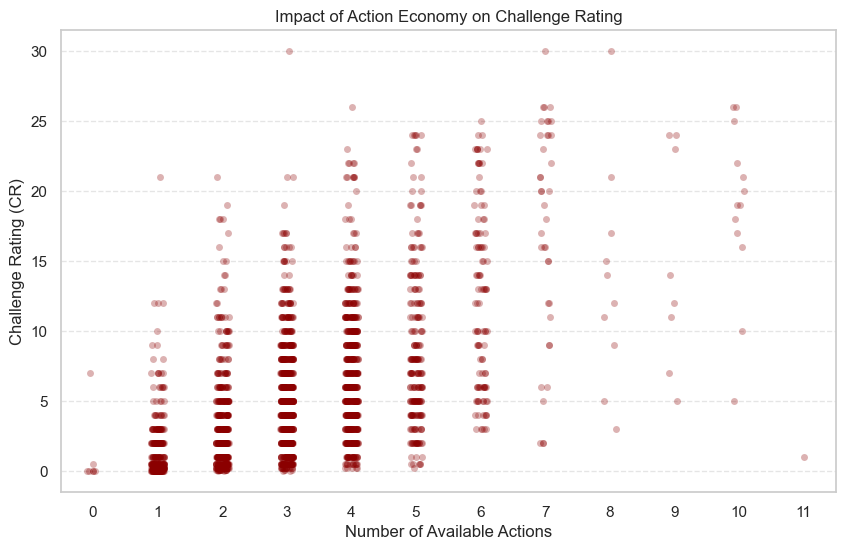

In [170]:
# 📊 GRAPH 3
plt.figure(figsize=(10, 6))
sns.stripplot(x='actions_count', y='cr', data=df, alpha=0.3, color='darkred', size=5, jitter=True)
plt.title('Impact of Action Economy on Challenge Rating')
plt.xlabel('Number of Available Actions')
plt.ylabel('Challenge Rating (CR)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [171]:
# ## Phase 5: Domain Imputation & Metric Conversion
#
# ### 🛠️ Transformation: Filling Missing Skills
# The dataset has many `NaN` in skills (e.g., Stealth). In D&D, a missing skill doesn't mean "0 ability". It means the monster uses its raw Attribute Modifier.
#
# * **Logic:** If `stealth` is missing, fill with `(Dexterity - 10) // 2`.
# * **Metric Conversion:** Convert feet to meters (x 0.3) for scientific standardization.


In [172]:
print("\n--- PHASE 4: Imputation & Metric Conversion ---")

# 1. Senses & Languages Parsing
if 'senses' in df.columns:
    senses = df['senses'].fillna('').astype(str)
    # Extract Passive Perception
    pp = pd.to_numeric(senses.str.extract(r'passive perception\s+(\d+)', re.I, expand=False)).fillna(0).astype(int)
    if 'passive_perception' not in df.columns: df['passive_perception'] = pp
    df = df.drop(columns=['senses'])

if 'languages' in df.columns:
    # Just count languages
    df['languages_count'] = df['languages'].apply(count_simple)
    df = df.drop(columns=['languages'])

# 2. Speed Cleaning (Metric)
speed_cols = [c for c in df.columns if 'speed.' in c and df[c].dtype == float]
df[speed_cols] = df[speed_cols].mul(0.3).round(1) # Feet to Meters
# Fix Hover (Boolean mixed types)
if 'speed.hover' in df.columns:
    df['speed.hover'] = np.where(df['speed.hover'].astype(str).str.contains("True|1", case=False), 1, 0)

# 3. Intelligent Imputation (D&D Rules)
skill_map = {
    "skills.athletics": "strength", "skills.stealth": "dexterity", "skills.acrobatics": "dexterity",
    "skills.perception": "wisdom", "skills.insight": "wisdom", "skills.arcana": "intelligence",
    "skills.survival": "wisdom", "skills.deception": "charisma", "skills.intimidation": "charisma",
    "skills.persuasion": "charisma", "skills.medicine": "wisdom", "skills.nature": "intelligence",
    "skills.religion": "intelligence", "skills.history": "intelligence", "skills.investigation": "intelligence",
    "skills.performance": "charisma", "skills.sleight_of_hand": "dexterity", "skills.animal_handling": "wisdom"
}

# Ensure numeric columns have 0 instead of NaN before calculation
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(0)

for skill, stat in skill_map.items():
    if skill in df.columns and stat in df.columns:
        # Calculate Modifier: (Score - 10) / 2 rounded down
        mod = (df[stat] - 10) // 2
        # Apply modifier only where skill is 0 (missing)
        df[skill] = np.where(df[skill] == 0, mod, df[skill])

print("✅ Imputation complete.")



--- PHASE 4: Imputation & Metric Conversion ---
✅ Imputation complete.


In [173]:
# ### 📊 Graph 4: Quality Assurance
# **Final Missing Values Map**
#
# * *Goal:* The plot should be entirely green (or whatever the background color is), with no yellow lines. This confirms the dataset is fully dense and ready for math.


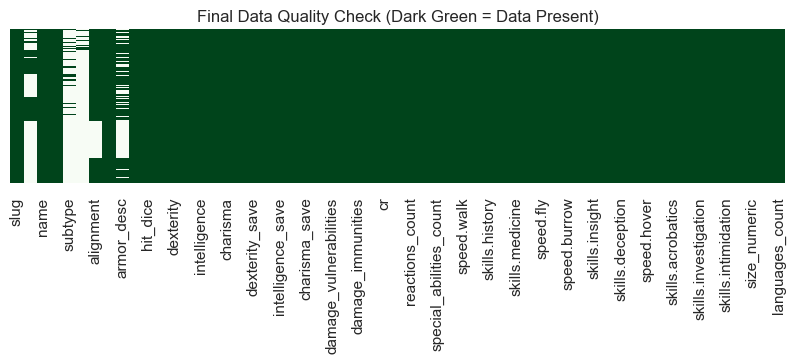

In [174]:
# 📊 GRAPH 4
plt.figure(figsize=(10, 2))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='Greens_r')
plt.title('Final Data Quality Check (Dark Green = Data Present)')
plt.show()


In [175]:
# ## Phase 6: Encoding & Finalization
#
# ### 🛠️ Final Steps
# 1.  **One-Hot Encoding:** Convert `type` (Dragon, Fiend) into binary columns.
# 2.  **Constant Removal:** **(CRITICAL FIX)** Identify and remove columns where every row has the same value (Variance = 0). These columns cause `RuntimeWarning: invalid value encountered in divide` during correlation calculation.
# 3.  **Saving:** Export the clean CSV.





--- PHASE 5: Encoding & Final Save ---
✅ Removed 0 constant/dead columns.

💾 DATASET SAVED: ./data/monsters_test.csv
   Final Shape: (2435, 65)


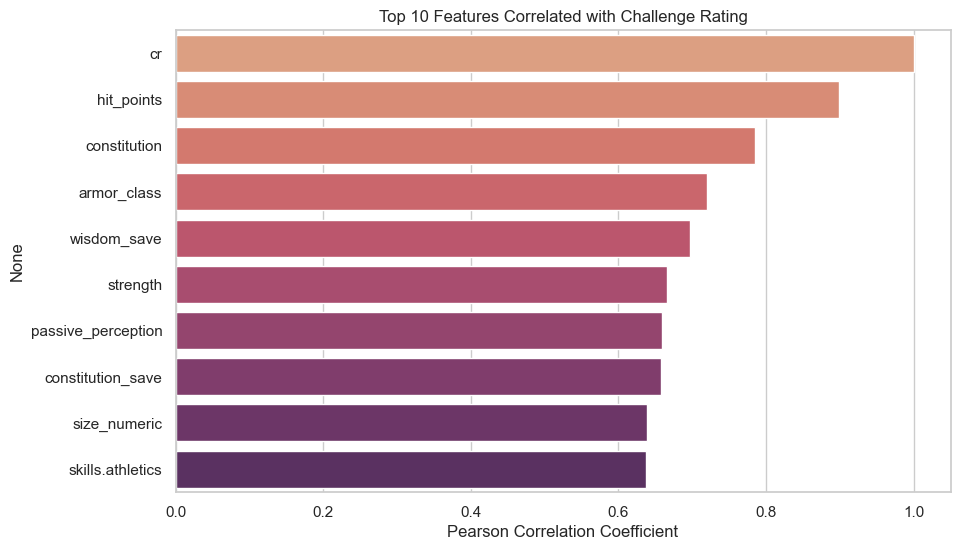

In [176]:
print("\n--- PHASE 5: Encoding & Final Save ---")

# 1. Remove High Cardinality Columns
if 'sub_race' in df.columns:
    df = df.drop(columns=['sub_race'])

# 2. One-Hot Encode 'Type'
if 'type' in df.columns:
    dummies = pd.get_dummies(df['type'], prefix='type', dtype=int)
    idx = df.columns.get_loc('type')
    # Insert new columns exactly where 'type' was
    df = pd.concat([df.iloc[:, :idx], dummies, df.iloc[:, idx+1:]], axis=1)

# 3. Remove remaining Text columns (except Name)
cols_text = df.select_dtypes(include=['object']).columns
if len(cols_text) > 1:
    drop = [c for c in cols_text if c != 'name']
    df = df.drop(columns=drop)

# 4. 🛠️ FIX RUNTIME WARNING: Remove Constant Columns
# We filter columns where Standard Deviation is 0.
numeric_df = df.select_dtypes(include=[np.number])
# Keep columns where std > 0
valid_cols = numeric_df.columns[numeric_df.std() > 0]
# Add 'name' back to list of columns to keep
cols_to_keep = ['name'] + list(valid_cols)
# Filter DataFrame
df = df[cols_to_keep]

print(f"✅ Removed {len(numeric_df.columns) - len(valid_cols)} constant/dead columns.")

# 5. Save
output_file = "./data/monsters_test.csv"
try:
    df.to_csv(output_file, index=False)
    print(f"\n💾 DATASET SAVED: {output_file}")
    print(f"   Final Shape: {df.shape}")
except:
    print(f"❌ Error saving to {output_file}. Check permissions.")

# 📊 GRAPH 5: Top Correlations (Bug-Free)
# We only calculate correlations on the valid, non-constant columns
if 'cr' in df.columns:
    numeric_df = df.select_dtypes(include=[np.number])
    corr_with_cr = numeric_df.corrwith(df['cr']).sort_values(ascending=False)
    top_10 = corr_with_cr.head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_10.values, y=top_10.index, hue=top_10.index, palette="flare", legend=False)
    plt.title('Top 10 Features Correlated with Challenge Rating')
    plt.xlabel('Pearson Correlation Coefficient')
    plt.show()
